# Simulation

In [14]:
import numpy as np

class Agent:
    def __init__(self, probs, user_type, user_id=None):
        self._mean_time = probs.loc['dt_mean']
        self._std_time = probs.loc['dt_std']
        self._probs = probs.drop(['dt_mean', 'dt_std', 'Accumulated Lost', 'Accumulated Passed'])
        self._probs = self._probs / self._probs.sum(0)
        self._state = 1
        self.user_type = user_type
        if user_id is None:
            user_id = np.random.randint(1e12)
        self.user_id = user_id
        self._track = pd.DataFrame(columns=['user_pseudo_id', 'event_timestamp', 'event_name', 'user_type'])
        self._current_time = 0

    def _step(self):
        probs = self._probs.loc[:, str(self._state)]
        vals = probs.index
        probs = probs.values
        next_step = np.random.choice(vals, p=probs)
        return next_step
    
    def _delay(self):
        mu = self._mean_time.loc[str(self._state)]
        sigma = self._std_time.loc[str(self._state)]
        time = np.random.normal(loc=mu, scale=sigma, size=1)[0]
        return np.exp(time + 1e-6)
    
    def simulate(self):
        while (self._state != -1) and (self._state < self._probs.shape[1]):
            self._current_time += self._delay()
            event = self._step()
            self._track = self._track.append({
                'user_pseudo_id': self.user_id,
                'event_timestamp': self._current_time,
                'event_name': event,
                'user_type': self.user_type
            }, ignore_index=True)
            if event != 'lost':
                self._state += 1
            else:
                self._state = -1
        return self._track

In [15]:
class Simulator:
    def __init__(self, path, pops=None):
        self._population = self.create_population(path, pops)
        self.clickstream = pd.DataFrame(columns=['user_pseudo_id', 'event_timestamp', 'event_name', 'user_type'])
    
    def create_population(self, path, pops=None):
        dyn_mat = os.path.join(path, 'dynamic_matrix')
        stats = os.path.join(path, 'stats')
        files = os.listdir(dyn_mat)
        agents = []
        for idx, file in enumerate(sorted(files)):
            if pops is None:
                agents_num = pd.read_csv(os.path.join(stats, file)).users_count.iloc[0]
            else:
                agents_num = pops[idx]
            clus_dyn = pd.read_csv(os.path.join(dyn_mat, file), index_col=[0])
            for i in range(agents_num):
                agents.append(Agent(clus_dyn, file.split('_')[1].split('.')[0]))
        return agents
    
    def simulate(self):
        for agent in self._population:
            self.clickstream = self.clickstream.append(agent.simulate())
        return self.clickstream

In [28]:
sim = Simulator(path, [100] * 10)
clicks = sim.simulate()

In [35]:
clicks.head()

,user_pseudo_id,event_timestamp,event_name,user_type,event_rank
0,694017314218,0.000002,onboarding_welcome_screen,-1,1
1,694017314218,8.253703,sleep_1,-1,1
2,694017314218,8.253705,onboarding__chooseLoginType,-1,1
3,694017314218,9.491023,sleep_0,-1,1
4,694017314218,9.491025,onboarding_privacy_policyShown,-1,1


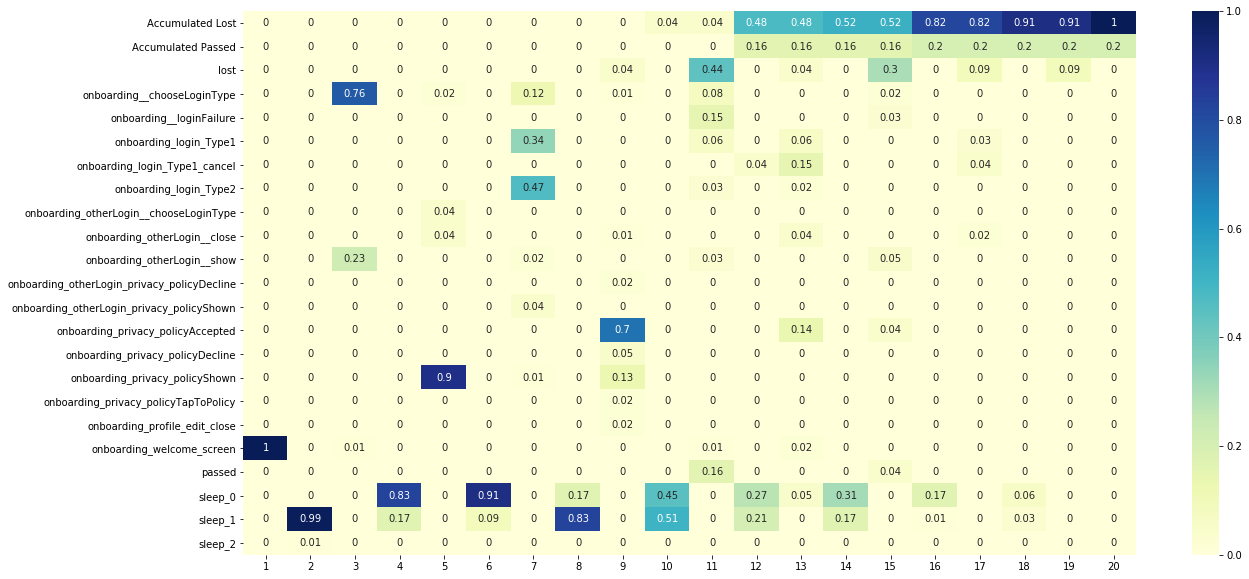

In [29]:
analysis.get_desc_table(clicks[clicks.user_type == '-1'], settings={});

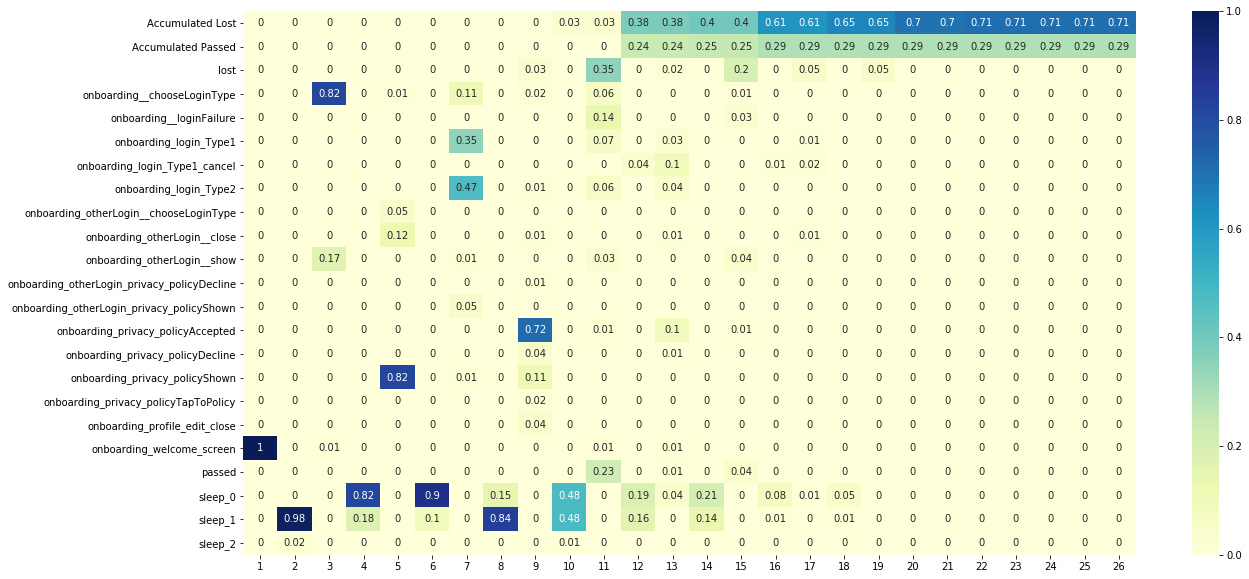

In [27]:
import seaborn as sns
sns.mpl.pyplot.rcParams['figure.figsize'] = [20, 10]
sns.heatmap(pd.read_csv('./experiments/track-simulator/dynamic_matrix/cluster_-1.csv',
                        index_col=0).drop(['dt_mean', 'dt_std']), annot=True, cmap="YlGnBu")